<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Modelos ARIMA - Como Determinar os Valores de p, d e q</font></b></strong>

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import pmdarima
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from pandas.plotting import autocorrelation_plot

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
#plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [9]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

statsmodels 0.11.1
pandas      1.0.5
pmdarima    1.6.1
sklearn     0.23.1
matplotlib  3.3.0
numpy       1.16.6
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [11]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')

In [12]:
# Dados
dataframe.head()

,Data,QT_INTER
0,2010-01-01,670
1,2010-01-02,671
2,2010-01-03,708
3,2010-01-04,1463
4,2010-01-05,1424


In [13]:
# Tipos de dados
dataframe.dtypes

Data        datetime64[ns]
QT_INTER             int64
dtype: object

In [14]:
# Shape
dataframe.shape

(3287, 2)

In [15]:
# Refinamos os dados para o gráfico da série original

# Definimos o índice do dataset
dataframe.index = dataframe['Data']

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['QT_INTER']

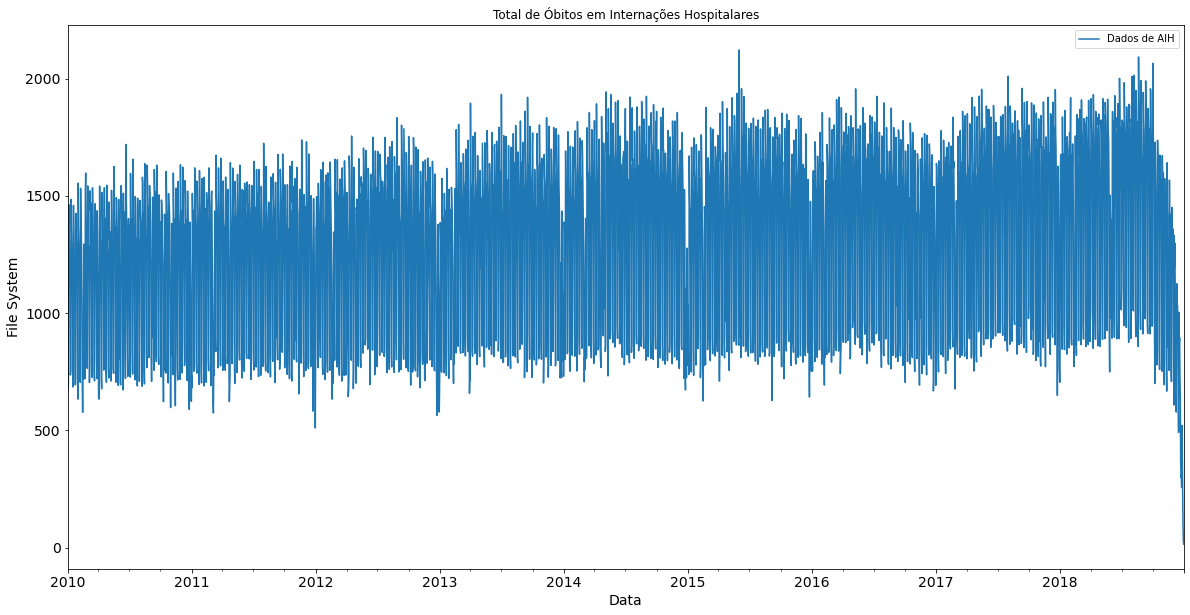

In [16]:
# Plot
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

target.plot(title = 'Total de Óbitos em Internações Hospitalares', fontsize = 14, label = 'Dados de AIH') 
plt.xlabel("Data") 
plt.ylabel("File System") 
plt.legend(loc = 'best') 
plt.show()

## Determinando o Valor do Parâmetro d para o Modelo ARIMA

In [17]:
# Teste ADF       ERRADO   #############################################################
#resultado = adfuller(dataframe['Arrecadacao'])
#print('Estatística ADF: %f' % resultado[0])
#print('Valor-p: %f' % resultado[1])

In [18]:
# Teste ADF
resultado = adfuller(target)
print('Estatística ADF: %f' % resultado[0])
print('Valor-p: %f' % resultado[1])

Estatística ADF: -37.001163
Valor-p: 0.000000


O valor-p é maior que 0.05, portanto, precisamos calcular o valor de 'd' pelo Modelo ARIMA.

Você aceitará a hipótese nula e poderá inferir que a série temporal é não estacionária.

Vamos fazer mais uma checagem. Vamos aplicar a diferenciação duas vezes a nossa série e comparar os gráficos ACF.

A função np.diff() aplica a diferenciação.

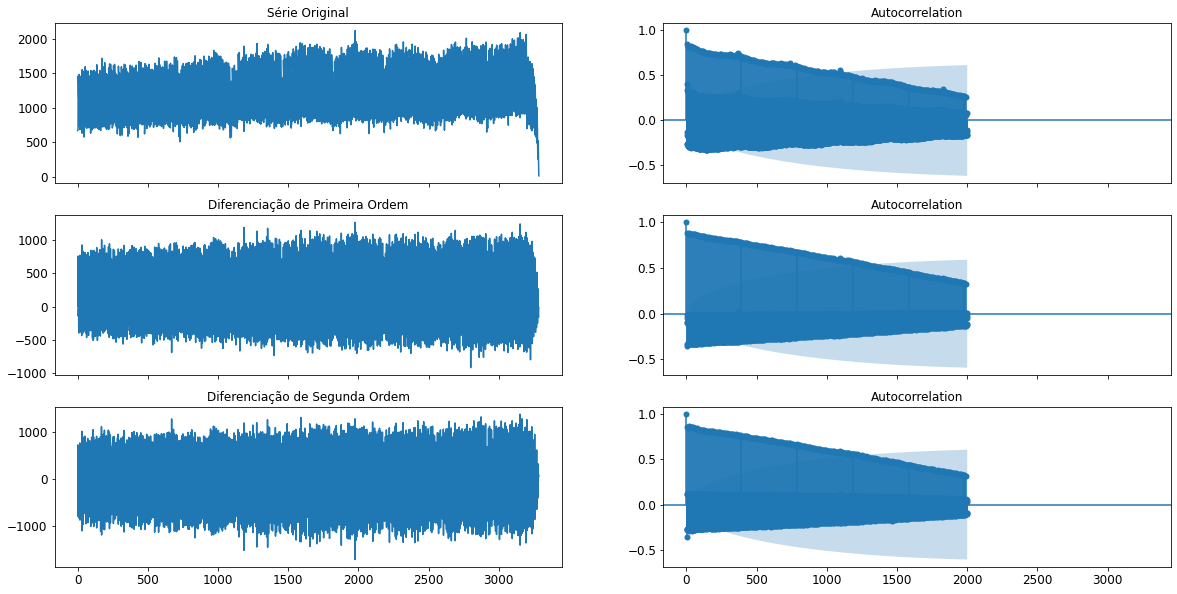

In [19]:
# Área de Plotagem
fig, axes = plt.subplots(3, 2, sharex = True)

# Série Original
axes[0, 0].plot(target.values); axes[0, 0].set_title('Série Original')
plot_acf(target.values, lags = 2000, ax = axes[0, 1])

# Diferenciação de Primeira Ordem
axes[1, 0].plot(np.diff(target.values)); axes[1, 0].set_title('Diferenciação de Primeira Ordem')
plot_acf(np.diff(target.values), lags = 2000, ax = axes[1, 1])

# Diferenciação de Segunda Ordem
axes[2, 0].plot(np.diff(np.diff(target.values))); axes[2, 0].set_title('Diferenciação de Segunda Ordem')
plot_acf(np.diff(np.diff(target.values)), lags = 2000, ax = axes[2, 1])

plt.show()

Fica claro que a Diferenciação de Primeira Ordem distribuiu melhor a série. Ou seja, o valor d = 1 parece ser uma boa opção para o Modelo ARIMA.

Mas a Diferenciação de Primeira Ordem e Segunda Ordem estão bem parecidas. Por que não d = 2?

Afinal, a série temporal atinge a estacionariedade com duas ordens de diferenciação. Mas, olhando para o gráfico de autocorrelação para a segunda diferencial, o atraso (lag) entra na zona negativa distante (-0.5) razoavelmente rápido, o que indica que a série pode ter sido super diferenciada.

Portanto, a Diferenciação de Primeira Ordem parece ser mesmo a melhor opção, mesmo que a série não seja perfeitamente estacionária (fraca estacionariedade). Ou seja, d = 1. 

Mas espere, tenho mais um teste com a função ndiffs:

https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html

Não fique bravo(a), mas tudo que foi feito acima poderia ser testado com o comando abaixo....hehehe. Mas eu tinha que fazer meu trabalho e explicar as coisas para você. :-)

In [20]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [21]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

Ou seja, o Teste ADF indicou d = 1 e o Teste KPSS indicou d = 1.

Vamos escolher d = 1 pois vimos no gráfico a diferença quando aplicamos a primeira diferenciação. A escolha é sua meu caro(a) Cientista de Dados.

Já temos o I de ARIMA, o parâmetro d. Agora vamos encontrar o termo AR, com o parâmetro p.

## Já temos o I de ARIMA (p, d, q), o parâmetro d = 1

## Determinando o Valor do Parâmetro p para o Modelo ARIMA

A próxima etapa é identificar se o modelo precisa de termos AR. Você pode descobrir o número necessário de termos AR, inspecionando o gráfico PACF (Partial Autocorrelation). Mas o que é PACF?

A autocorrelação parcial pode ser imaginada como a correlação entre a série e seu atraso, após excluir as contribuições dos atrasos intermediários. Portanto, o PACF meio que transmite a correlação pura entre um atraso e a série. Dessa forma, você saberá se esse atraso é necessário no termo AR ou não.

Qualquer autocorrelação em uma série estacionarizada pode ser retificada adicionando termos AR suficientes. Portanto, inicialmente consideramos a ordem do termo AR igual a tantas defasagens que ultrapassam o limite de significância no gráfico PACF.

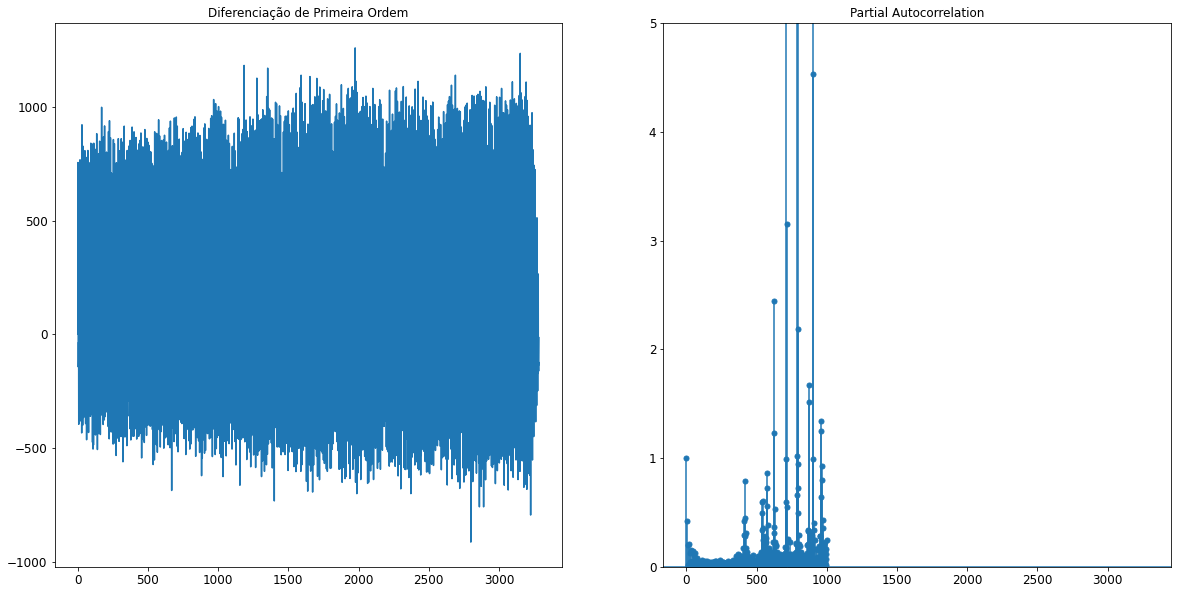

In [22]:
# Gráfico PACF
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(np.diff(target.values)); axes[0].set_title('Diferenciação de Primeira Ordem')
axes[1].set(ylim = (0,5))
plot_pacf(np.diff(target.values), lags = 1000, ax = axes[1])
plt.show()

Humm... O gráfico PACF não está ajudando muito. Tudo bem, tenho mais uma ferramenta aqui na manga. Sabe como é. Quanto mais ferramentas você conhece, mais problemas você é capaz de resolver. Já dizia aquele instrutor da DSA.

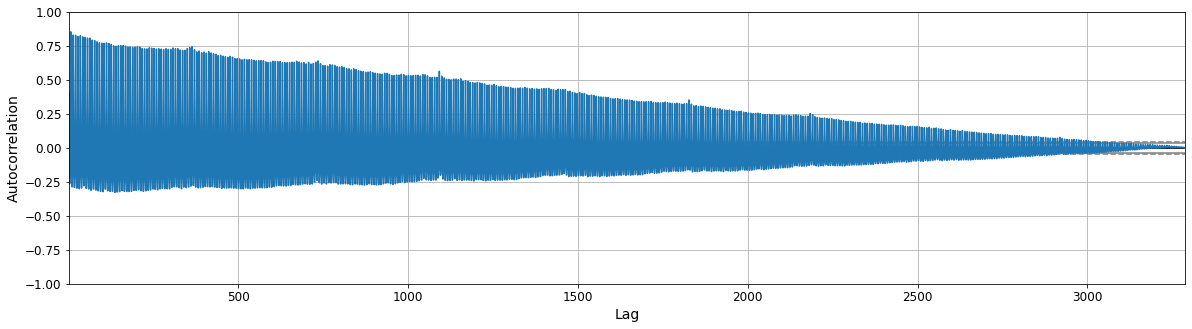

In [23]:
# Autocorrelation Plot
plt.figure(figsize = [20,5]) 
autocorrelation_plot(target)
plt.show()

Você pode observar que o atraso (lag) 1 é bastante significativo, pois está bem acima da linha de significância. O atraso 2 também é significativo, conseguindo ultrapassar o limite de significância. Mas vou ser conservador e definir o valor do parâmetro p igual a 1. Já temos o termo AR. Falta um. 

## Já temos o AR e I de ARIMA (p, d, q), os parâmetros p = 1, d = 1

## Determinando o Valor do Parâmetro q para o Modelo ARIMA

Assim como observamos o gráfico PACF para o número de termos AR, você pode observar para o gráfico ACF para o número de termos MA. Um termo MA é tecnicamente o erro da previsão atrasada.

O ACF informa quantos termos MA são necessários para remover qualquer autocorrelação na série estacionarizada.

Vamos ver o gráfico de autocorrelação das séries diferenciadas.

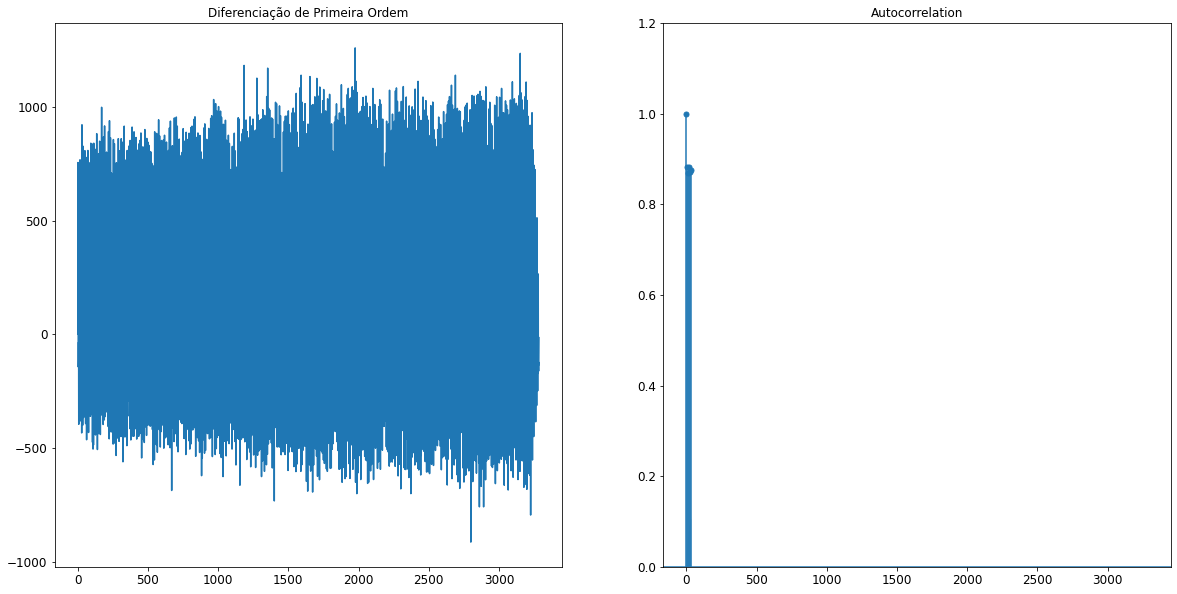

In [24]:
# Gráfico ACF
fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(np.diff(target.values)); axes[0].set_title('Diferenciação de Primeira Ordem')
axes[1].set(ylim = (0,1.2))
plot_acf(np.diff(target.values), ax = axes[1])
plt.show()

O gráfico de autocorrelação indica que temos pelo menos um valor acima do limite de 0.2. Ou seja, q = 1 é o mínimo que deveríamos testar, embora o q = 2 seja uma opção. Você pode testar as duas opções se desejar, mas eu vou escolher q = 1.

## Já temos todos os parâmetros de ARIMA (p, d, q) (1, 1, 1), p = 1, d = 1, q = 1

Para quem gosta de regras, aqui está uma lista completa:

https://people.duke.edu/~rnau/arimrule.htm

Já temos os 3 parâmetros para o Modelo ARIMA (p, d, q) - order(1, 1, 1).

Mas espere. Nós tínhamos criado o Modelo ARIMA na Aula 13 com order (2, 1, 0). Ok, vamos alterar o modelo e ver o que acontece. 

Vamos preparar os dados para o modelo.

# Fim